In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
#import squidpy as sq
from tqdm import tqdm

In [3]:
import sys
import os 
from pathlib import Path

In [4]:
notebook_dir = os.getcwd()
notebook_dir

'/Users/omercagatay/Desktop/Thesis/git_repo/SALMON/notebooks/metrics'

In [7]:
Path(notebook_dir).parents[3]

PosixPath('/Users/omercagatay/Desktop/Thesis')

In [8]:
os.chdir(Path(notebook_dir).parents[3])

In [9]:
import sys  
sys.path.insert(1,'/Users/omercagatay/Desktop/Thesis/git_repo/SALMON')
from SALMON.points2regions import *
from SALMON.formatting import *
from SALMON.metrics import *
from SALMON.microenvironment_metrics import *

In [16]:

def perimeter(convexhull=''):
    perimeter = 0
    for i in range(len(convexhull)):
        j = (i + 1) % len(convexhull)
        perimeter += np.linalg.norm(convexhull[i] - convexhull[j])
    return perimeter

def morphology_characteristics(points='a'):
    from scipy.spatial import ConvexHull
    points=np.array([a['x_location'],a['y_location']]).transpose()
    rds=ConvexHull(points)
    # computing convex hull
    ch=np.array([points[rds.vertices,0], points[rds.vertices,1]]).transpose()
    #perimeter calculation
    peri=perimeter(ch)
    centroid = np.mean(points, axis=0)
    distances = np.linalg.norm(ch - centroid, axis=1)
    max_distance = np.max(distances)
    min_distance = np.min(distances)
    eccentricity = max_distance / min_distance
    #circularity
    circularity = 1 / eccentricity
    return peri,eccentricity,circularity 

In [ ]:
###to be developed####
def compute_knn_read_distance(adatafilt):

    subdata = sc.AnnData(obs=adatafilt.uns['spots'])
    subdata.obsm['spatial'] = np.array([adatafilt.uns['spots']['x_location'],adatafilt.uns['spots']['y_location']]).transpose()
    sq.gr.spatial_neighbors(subdata,n_neighs=1,coord_type = 'generic')
    n=0
    tr=subdata.obsp['spatial_distances'].transpose()
    tr2=tr>0
    knndist=tr2.dot(subdata.obsm['spatial'])
    subdata.obs['closest_spot_distance']=np.sqrt(np.sum((subdata.obsm['spatial']-knndist)**2,axis=1))
    #compute, per cell, the density [TO IMPLEMENT]
    
    return adatafilt

# Read Data 

## Cell Feature Matrix

In [12]:
adata = sc.read_10x_h5('data/Xenium_V1_mouse_pup_outs/cell_feature_matrix.h5') 
#adata = sc.read('data/Xenium_V1_mouse_pup_outs/adata_filtered.h5ad') 

In [13]:
adata.var = adata.var.rename(columns={"gene_ids":"Ensemble ID"})
adata.var.reset_index(inplace=True, drop = False, names= "gene_name")
adata.obs.reset_index(inplace=True, drop=False, names= "cell_id")

## Cell Summary 

In [14]:
df_cells = pd.read_csv("data/Xenium_V1_mouse_pup_outs/cells.csv.gz")

In [15]:
df_cells.cell_id.value_counts()

cell_id
aaaabgpa-1    1
jlcihdnp-1    1
jlcifjco-1    1
jlciffio-1    1
jlcienmn-1    1
             ..
enilhfik-1    1
enilhckc-1    1
enilegml-1    1
enildhge-1    1
oinfkihb-1    1
Name: count, Length: 1355849, dtype: int64

In [16]:
df_adata_obs = df_cells[['cell_id','x_centroid',"y_centroid", "transcript_counts", "total_counts", "cell_area", "nucleus_area"]]

In [17]:
adata.obs = df_adata_obs.copy()

In [18]:
del df_adata_obs
del df_cells

## Transcripts

In [19]:
transcripts = pd.read_csv("data/Xenium_V1_mouse_pup_outs/transcripts_filtered.csv")

In [20]:
transcripts["cell_mapped"] = transcripts["cell_id"].apply(lambda x: "unassigned" if x == "UNASSIGNED" else "assigned")

In [21]:
tr = transcripts[transcripts["cell_id"] != "UNASSIGNED" ]
tr.reset_index(inplace=True, drop=True)
tr = tr.drop(columns=["Unnamed: 0"])

In [23]:
tr

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,cell_mapped
0,282162171478024,cfbhgalg-1,0,Fxyd6,1927.0404,4950.6410,27.462738,36.826744,G4,14.152650,assigned
1,282162171478026,cfbhgalg-1,0,Sypl2,1930.1780,4960.1475,27.615625,40.000000,G4,13.390779,assigned
2,282162171478034,cfbhgalg-1,0,Anxa2,1939.3625,4963.5310,30.198410,36.826744,G4,11.156137,assigned
3,282162171478036,cfbhgalg-1,0,Fech,1939.6849,4946.4624,27.285930,40.000000,G4,4.113297,assigned
4,282162171478056,cfaiacmp-1,0,Cryab,1944.0469,4972.1743,26.068003,40.000000,G4,5.479392,assigned
...,...,...,...,...,...,...,...,...,...,...,...
7989142,282187942270866,amiiijhf-1,1,Krt19,5756.5327,5549.8228,26.122461,26.422700,H10,0.000000,assigned
7989143,282187942270897,amiiijhf-1,1,Krt19,5757.9770,5550.0537,21.278362,40.000000,H10,0.000000,assigned
7989144,282187942270904,amiibcmi-1,0,Krt19,5758.3780,5534.4660,23.390993,28.166980,H10,1.227634,assigned
7989145,282187942270950,amiiijhf-1,1,Krt19,5761.3994,5548.9434,25.935236,40.000000,H10,0.000000,assigned


In [24]:
tr_both = tr.groupby('cell_id')['overlaps_nucleus'].agg(
    takes_0=lambda x: 1 if 0 in x.values else 0,
    takes_1=lambda x: 1 if 1 in x.values else 0,
    takes_both=lambda x: 1 if {0, 1}.issubset(x.values) else 0
).reset_index()

tr = tr.merge(tr_both, on="cell_id", how="left" )
tr = tr[tr["takes_both"]==1]


In [44]:
tr_both.takes_1.value_counts()

takes_1
1    39745
0      235
Name: count, dtype: int64

In [28]:
tr_both.takes_both.value_counts()

takes_both
1    39745
0      235
Name: count, dtype: int64

In [25]:
tr = tr.merge(tr_both, on="cell_id", how="left" )

In [29]:
tr = tr[tr["takes_both"]==1]

In [31]:
tr = tr.drop(columns=["takes_0","takes_1","takes_both"])

In [32]:
#cell_tr = pd.crosstab(tr['cell_id'],tr['feature_name'])
#adata = adata[adata.obs['cell_id'].isin(cell_tr.index)]

In [33]:
adata

View of AnnData object with n_obs × n_vars = 39980 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome'

In [32]:
# divide data in nuclei and cytopasm
tn = tr[tr['overlaps_nucleus'] == 1]
tc = tr[tr['overlaps_nucleus'] == 0]

# create the cellxgene matrix for nuc counts and cytoplasmic
nuc = pd.crosstab(tn['cell_id'],tn['feature_name'])
cyt = pd.crosstab(tc['cell_id'],tc['feature_name'])

In [37]:
adata.obs["cell_id"] == adata.obs["cell_id"].astype(str).astype('category')

17210      True
17211      True
17212      True
17213      True
17214      True
           ... 
1164208    True
1164209    True
1164210    True
1164211    True
1164212    True
Name: cell_id, Length: 39980, dtype: bool

In [33]:
adata.obs.index=adata.obs.index.astype(str).astype('category')

In [34]:
nuc.index = nuc.index.astype(str).astype("category")
cyt.index = cyt.index.astype(str).astype("category")

In [35]:
#get the cells which has a transcripts mappep to it 
adata = adata[adata.obs['cell_id'].isin(nuc.index)]
adata = adata[adata.obs['cell_id'].isin(cyt.index)]

In [36]:
# create "spliced", "unspliced" layers since scvelo looks for them
adata.obs.index=adata.obs.index.astype(str).astype('category')
nucsort = nuc.loc[adata.obs['cell_id'],adata.var["gene_name"]]
adata.obs.index=adata.obs.index.astype(str).astype('category')
cytsort = cyt.loc[adata.obs['cell_id'],adata.var["gene_name"]]

adata.layers['spliced'] = np.array(cytsort)
adata.layers['unspliced'] = np.array(nucsort)

/var/folders/n1/3rys77050fl0ptsh50jc4t_40000gn/T/ipykernel_2477/1740076899.py:7: ImplicitModificationWarning: Setting element `.layers['spliced']` of view, initializing view as actual.
  adata.layers['spliced'] = np.array(cytsort)
/opt/anaconda3/envs/scvelo/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [38]:
adata.uns['spots'] = tr

In [39]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [40]:
#adata.write("data/Xenium_V1_mouse_pup_outs/adata_filtered.h5ad")

In [10]:
adata = sc.read('data/Xenium_V1_mouse_pup_outs/adata_filtered.h5ad') 

In [11]:
adata

AnnData object with n_obs × n_vars = 39745 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome'
    uns: 'spots'
    obsm: 'spatial'
    layers: 'spliced', 'unspliced'

# Filter reads based on distance

- Xenium output has the nucleus distance information, next cell will be skipped.

In [ ]:
id2x=dict(zip(adata.obs['cell_id'],adata.obs['x_centroid']))
id2y=dict(zip(adata.obs['cell_id'],adata.obs['y_centroid']))

# if the dataset doesn't have info about distance to nucleus. How to compute it:
cellx=adata.uns['spots']['cell_id'].map(id2x)
celly=adata.uns['spots']['cell_id'].map(id2y)
adata.uns['spots']['nucleus_distance']=np.sqrt((adata.uns['spots']['x_location']-cellx)**2+(adata.uns['spots']['y_location']-celly)**2)
adata.obsm['spatial']=np.array([adata.obs['x_centroid'],adata.obs['y_centroid']]).transpose()

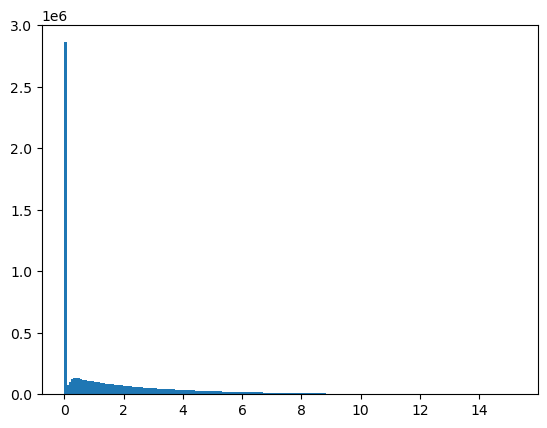

In [12]:
ss = plt.hist(adata.uns['spots']['nucleus_distance'],bins=200)

In [ ]:
#adata.obs['x_centroid'].max()
#adata=adata[adata.obs['x_centroid']<5000]
#adata=adata[adata.obs['y_centroid']<5000]

In [ ]:
#adata=filter_distant_reads(adata,max_distance=3)

In [61]:
adata

AnnData object with n_obs × n_vars = 39745 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_name', 'Ensemble ID', 'feature_types', 'genome'
    uns: 'spots'
    obsm: 'spatial'
    layers: 'spliced', 'unspliced'

In [13]:
adata.uns["spots"]

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,cell_mapped
0,282162171478024,cfbhgalg-1,0,Fxyd6,1927.0404,4950.6410,27.462738,36.826744,G4,14.152650,assigned
1,282162171478026,cfbhgalg-1,0,Sypl2,1930.1780,4960.1475,27.615625,40.000000,G4,13.390779,assigned
2,282162171478034,cfbhgalg-1,0,Anxa2,1939.3625,4963.5310,30.198410,36.826744,G4,11.156137,assigned
3,282162171478036,cfbhgalg-1,0,Fech,1939.6849,4946.4624,27.285930,40.000000,G4,4.113297,assigned
4,282162171478056,cfaiacmp-1,0,Cryab,1944.0469,4972.1743,26.068003,40.000000,G4,5.479392,assigned
...,...,...,...,...,...,...,...,...,...,...,...
7989142,282187942270866,amiiijhf-1,1,Krt19,5756.5327,5549.8228,26.122461,26.422700,H10,0.000000,assigned
7989143,282187942270897,amiiijhf-1,1,Krt19,5757.9770,5550.0537,21.278362,40.000000,H10,0.000000,assigned
7989144,282187942270904,amiibcmi-1,0,Krt19,5758.3780,5534.4660,23.390993,28.166980,H10,1.227634,assigned
7989145,282187942270950,amiiijhf-1,1,Krt19,5761.3994,5548.9434,25.935236,40.000000,H10,0.000000,assigned


# Functions 

- transcript_based_adata() function looks for gene_id 

In [15]:
adata.var = adata.var.rename(columns={"gene_name":"gene_id"})

### transcript_based_adata()

- Recomputes the adata.X

- Through the construction of the anndata object from Xenium outputs, we don't need to run this function again.

In [16]:
adatafilt = transcript_based_adata(adata)

In [17]:
adatafilt.obs.index = adatafilt.obs.index.astype(str).astype('category')
adatafilt.obs['cell_id'] = adatafilt.obs['cell_id'].astype(str).astype('category')
adatafilt.uns['spots']['cell_id'] = adatafilt.uns['spots']['cell_id'].astype(str).astype('category')
#adatafilt.obsm['spatial'] = np.array([adatafilt.obs['x_centroid'],adatafilt.obs['y_centroid']]).transpose()
adatafilt.uns['spots']['feauture_name'] = adatafilt.uns['spots']['feature_name'].astype(str)

### compute_nuclear_centroid()

calculates:

- center of the nucleic transcripts location
- distance between the center of all transcripts and nucleic transcripts 

In [31]:
adatafilt.obs["nuclei_centroid_x"]

ind
acpcjcfh-1    2490.826060
acpcjpmd-1    2487.099430
acpclemn-1    2482.666418
acpcloep-1    2482.874376
acpcmlbo-1    2486.129232
                 ...     
mhpomnnj-1    3360.217364
mhpopemo-1    3362.493752
mhpoplgm-1    3362.831592
mhppblnl-1    3364.047773
mhppbmhi-1    3353.683380
Name: nuclei_centroid_x, Length: 39745, dtype: category
Categories (39745, float64): [2490.826060, 2487.099430, 2482.666418, 2482.874376, ..., 3362.493752, 3362.831592, 3364.047773, 3353.683380]

In [18]:
adatafilt = compute_nuclear_centroid(adatafilt)

/Users/omercagatay/Desktop/Thesis/git_repo/SALMON/SALMON/metrics.py:207: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for a,g in tqdm(adatafilt.uns['spots'].groupby('cell_id')):
100%|██████████| 39745/39745 [00:08<00:00, 4820.10it/s]


In [29]:
adatafilt

AnnData object with n_obs × n_vars = 39745 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nuclei_centroid_x', 'nuclei_centroid_y', 'distance_centroid_to_nuccentroid', 'mean_polarity', 'max_polarity', 'polarity_pc', 'mean_distance_to_gene_centroids', 'nuc_and_cyt_genes', 'cyt_genes', 'nuc_genes', 'expressed_genes', 'nuc_and_cyt_genes_proportion', 'cyt_genes_proportion', 'nuc_genes_proportion', 'cyt_counts', 'nuc_counts', 'cyt_counts_proportion', 'nuc_counts_proportion'
    var: 'gene_id', 'Ensemble ID', 'feature_types', 'genome'
    uns: 'spots', 'nuclear_expression', 'cytoplasmic_expression'
    obsm: 'polarity', 'xgene', 'ygene'

In [19]:
adatafilt.obs["distance_centroid_to_nuccentroid"].isna().value_counts()

distance_centroid_to_nuccentroid
False    39745
Name: count, dtype: int64

### define_cell_polarities()

- Returns mean distance of the gene specific centroids to the cellular centroid.


In [20]:
adatafilt = define_cell_polarities(adatafilt)

/Users/omercagatay/Desktop/Thesis/git_repo/SALMON/SALMON/metrics.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for a,g in tqdm(adatafilt.uns['spots'].groupby('cell_id')):
100%|██████████| 39745/39745 [00:48<00:00, 818.33it/s]


### polarization_based_pca()

In [21]:
adatafilt = polarization_based_pca(adatafilt,min_gene_counts=2)

/Users/omercagatay/Desktop/Thesis/git_repo/SALMON/SALMON/metrics.py:145: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for a,g in tqdm(adatafilt.uns['spots'].groupby('cell_id')):
100%|██████████| 39745/39745 [00:57<00:00, 696.02it/s]


In [22]:
adatafilt

AnnData object with n_obs × n_vars = 39745 × 379
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nuclei_centroid_x', 'nuclei_centroid_y', 'distance_centroid_to_nuccentroid', 'mean_polarity', 'max_polarity', 'polarity_pc', 'mean_distance_to_gene_centroids'
    var: 'gene_id', 'Ensemble ID', 'feature_types', 'genome'
    uns: 'spots'
    obsm: 'polarity', 'xgene', 'ygene'

### nuclear_and_cytoplasmic_characteristics()

In [23]:
adatafilt = nuclear_and_cytoplasmic_characteristics(adatafilt,minimum_expression=1)

/Users/omercagatay/Desktop/Thesis/git_repo/SALMON/SALMON/metrics.py:85: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['nuclear_expression']=div_exp.loc[:,nuc_cols]


### compute_closest_neighbor_distance()

In [35]:
adatafilt.obsm["spatial"] = adatafilt.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
adatafilt = compute_closest_neighbor_distance(adatafilt)

### local_density_p2r()

In [36]:

adatafilt = local_density_p2r(adatafilt)

100%|██████████| 39745/39745 [02:06<00:00, 313.77it/s]


In [ ]:
def morphology_alphashape(adata,alphas):
    import os
    import sys
    import pandas as pd
    import numpy as np
    from descartes import PolygonPatch
    import matplotlib.pyplot as plt
    sys.path.insert(0, os.path.dirname(os.getcwd()))
    import alphashape
    from scipy.spatial import ConvexHull
    spot=adata.uns['spots']
    
    for cid in tqdm(adata.obs['cell_id'].unique()):
        a=spot[spot['cell_id'].isin([cid])]
        points=np.array([a['x_location'],a['y_location']]).transpose()
        alpha_shape = alphashape.alphashape(points, alphas)
        alpha_shape
        
    return peri,eccentricity,circularity 

In [ ]:
adatafilt

In [ ]:
#pe=morphology_alphashape(adata,2.0)

# Process adata and ct identification

In [37]:
adatafilt.var.index=adatafilt.var['gene_id']
adatafilt.raw=adatafilt
sc.pp.filter_cells(adatafilt,min_counts=20)
sc.pp.normalize_total(adatafilt)
sc.pp.log1p(adatafilt)


In [38]:
sc.pp.neighbors(adatafilt)
sc.tl.umap(adatafilt)
sc.tl.leiden(adatafilt)

In [39]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(6,6))
sc.pl.umap(adatafilt,color=['intracellular_min_correlation','intracellular_mean_correlation'],vmax='p99.9',vmin='p20',cmap='coolwarm',s=20,ncols=2,frameon=False)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x38b00f9c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(6,6))
sc.pl.umap(adatafilt,color=['intracellular_mean_correlation'],vmax='p99.9',cmap='coolwarm',vmin=0.8,s=2,ncols=2,frameon=False,colorbar_loc=None)

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(6,6))
sc.pl.umap(adatafilt,color=['nuc_counts_proportion','cyt_counts_proportion','distance_centroid_to_nuccentroid'],vmax='p99.9',cmap='viridis',s=2,ncols=2,frameon=False)

In [ ]:
sc.pl.umap(adatafilt,color=['leiden','nuc_genes_proportion','nuc_and_cyt_genes_proportion','cyt_genes_proportion'],vmax='p99.9',cmap='viridis',s=2,ncols=2)

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(15,15))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.spatial(adatafilt,spot_size=25,color=['leiden'])

In [ ]:
adatafilt=calcualte_densities(adatafilt)
adatafilt=nuclear_to_cytoplasmic_correlation(adatafilt)

In [ ]:
adatafilt=gene_nuclear_to_cytoplasmic_correlation(adatafilt)

In [ ]:
adatafilt=centrality_scores(adatafilt)

In [ ]:
adatafilt=format_data_neighs_radius(adatafilt,'leiden','sample',radius=100)

In [ ]:
magnitudes=['cell_area','nucleus_area','nuc_and_cyt_genes', 'cyt_genes', 'nuc_genes',
'expressed_genes','nuc_and_cyt_genes_proportion', 'cyt_genes_proportion','nuc_genes_proportion', 'cyt_counts', 'nuc_counts',
'n_counts', 'cyt_counts_proportion', 'nuc_counts_proportion','distance_centroid_to_nuccentroid',
           'cell_density','nuc_density','cyt_density','cyt_nuc_correlation','neighborhood_diversity', 'neighborhood_density',
           'intracellular_min_correlation','intracellular_mean_correlation','closest_cell_distance','mean_polarity', 'max_polarity','polarity_pc', 'mean_distance_to_gene_centroids']

In [ ]:
scores=adatafilt.obs[magnitudes]

In [ ]:
scores.astype(float)

In [ ]:
scores=adatafilt.obs[magnitudes]
scores=scores.astype(float).dropna(axis=0)
resu=pd.DataFrame(index=magnitudes,columns=magnitudes)
plt.figure(figsize=(15,15),dpi=400)
for mag in magnitudes:
    for mag2 in magnitudes:
        resu.loc[mag,mag2]=np.corrcoef(scores[mag].astype(float),scores[mag2].astype(float))[0,1]
sns.clustermap(resu.astype(float),cmap='coolwarm',figsize=(15,15))

# Questions about the data ###

## QUESTION 1: How are genes distributed in compartments?

In [ ]:
sub=adatafilt.obs.loc[:,['nuc_genes_proportion','nuc_and_cyt_genes_proportion','cyt_genes_proportion']]
sub2=sub.stack().reset_index()
sub2['level_1']=sub2['level_1'].str.replace('_proportion','')
sub2.columns=['ind','level_1','proportion']
plt.figure(figsize=(3,2))
sns.violinplot(data=sub2,y=sub2['level_1'],x=sub2['proportion'])

## QUESTION 2: How are counts distributed in nuclei vs cytoplasm? 

In [ ]:
sub=adatafilt.obs.loc[:,['nuc_counts_proportion','cyt_counts_proportion']]
sub2=sub.stack().reset_index()
sub2['level_1']=sub2['level_1'].str.replace('_proportion','')
sub2.columns=['ind','level_1','proportion']
plt.figure(figsize=(3,2))
sns.violinplot(data=sub2,y=sub2['level_1'],x=sub2['proportion'])

## QUESTION 3: How are the areas of each compatment?

In [ ]:
sub=adatafilt.obs.loc[:,['nucleus_area','cell_area','cytoplasm_area']]
sub2=sub.stack().reset_index()
sub2['level_1']=sub2['level_1'].str.replace('_proportion','')
sub2.columns=['ind','level_1','read/area']
plt.figure(figsize=(6,2),dpi=200)
sns.violinplot(data=sub2,y=sub2['level_1'],x=sub2['read/area'])

## QUESTION 4: Is the cell Area dependent on cell type?

In [ ]:
sub=adatafilt.obs.loc[:,['cell_area','leiden']]
plt.figure(figsize=(20,4),dpi=200)
sns.violinplot(data=sub,x=sub['leiden'],y=sub['cell_area'])

In [ ]:
sub=adatafilt.obs.loc[:,['nucleus_area','leiden']]
plt.figure(figsize=(20,4),dpi=100)
sns.violinplot(data=sub,x=sub['leiden'],y=sub['nucleus_area'])

## QUESTION 5: How does the compartment density behave?

In [ ]:
sub=adatafilt.obs.loc[:,['nuc_density','cell_density','cyt_density']]
sub2=sub.stack().reset_index()
sub2['level_1']=sub2['level_1'].str.replace('_proportion','')
sub2.columns=['ind','level_1','read/area']
plt.figure(figsize=(6,4),dpi=100)
sns.violinplot(data=sub2,y=sub2['level_1'],x=sub2['read/area'])

In [ ]:
for mg in magnitudes:
    sc.pl.violin(adatafilt,mg,groupby='leiden',figsize=(10,3))

In [ ]:
adatafilt.var.sort_values(by='nuc_cyt_correlation',ascending=False).head(20)

In [ ]:
sc.set_figure_params(scanpy=True, dpi=70,figsize=(8,8))
sc.pl.umap(adatafilt,color=['cyt_nuc_correlation','leiden'],ncols=2,frameon=False,s=4,cmap='coolwarm')

In [ ]:
sc.set_figure_params(scanpy=True, dpi=200,figsize=(15,7))
sc.pl.violin(adatafilt,keys='polarity_pc',groupby='leiden',swap_axes=True)

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(15,15))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.spatial(adatafilt,spot_size=25,color=['polarity_pc'],cmap='Blues')

# NMF

In [ ]:
# NMF
from sklearn.decomposition import NMF
import numpy as np

# Assuming your expression matrix is stored in a variable named "expression_matrix"
# Make sure it's a numpy array and contains non-negative values
# Replace this with your actual data
expression_matrix = adatafilt.X

# Define the number of components (factors) for NMF
n_components = 10

# Initialize the NMF model
model = NMF(n_components=n_components, init='random', random_state=0)

# Fit the model to your expression matrix
W = model.fit_transform(expression_matrix)
H = model.components_

# Now W and H contain the factorized matrices
# W represents the sample-feature matrix
# H represents the feature-gene matrix


In [ ]:
contr=pd.DataFrame(H,columns=adatafilt.var.index)
contr2=contr.loc[:,np.max(contr,axis=0)>0.6]
sns.clustermap(contr2,figsize=(30,20))

In [ ]:
factous=pd.DataFrame(W,columns=['factor'+str(i) for i in  range(0,W.shape[1])])
for c in factous.columns:
    adatafilt.obs.loc[:,c]=list(factous.loc[:,c])
adatafilt.obs['max_factor']=np.max(adatafilt.obs[factous.columns],axis=1)/np.sum(adatafilt.obs[factous.columns],axis=1)
sc.pl.umap(adatafilt,color=['max_factor'],ncols=2,frameon=False,s=50,cmap='coolwarm')
sc.pl.umap(adatafilt,color=factous.columns,ncols=2,frameon=False,s=50,cmap='coolwarm')

In [ ]:
adatafilt.obs[factous.columns]

In [ ]:
adatafilt.obs[magnitudes]

In [ ]:
sc.pl.dotplot(adatafilt,factous.columns,groupby='leiden')

In [ ]:
scores=adatafilt.obs[list(magnitudes)+list(factous.columns)+list(['max_factor'])]
scores=scores.astype(float).dropna(axis=0)
resu=pd.DataFrame(index=magnitudes,columns=list(factous.columns)+list(['max_factor']))
plt.figure(figsize=(15,15),dpi=400)
for mag in magnitudes:
    for mag2 in list(factous.columns)+list(['max_factor']):
        resu.loc[mag,mag2]=np.corrcoef(scores[mag].astype(float),scores[mag2].astype(float))[0,1]
sns.clustermap(resu.astype(float),cmap='coolwarm',figsize=(15,15),vmax=1,vmin=-1)

# Nuclear vs cytoplasmic expression

In [ ]:
nuc_ann=sc.AnnData(adatafilt.uns['nuclear_expression'].loc[adatafilt.obs['cell_id'],:],obs=adatafilt.obs)
nuc_ann.obs['nuc_cyt']='nuc'
cyt_ann=sc.AnnData(adatafilt.uns['cytoplasmic_expression'].loc[adatafilt.obs['cell_id'],:],obs=adatafilt.obs)
cyt_ann.obs['nuc_cyt']='cyt'

In [ ]:
gen=[e for e in cyt_ann.var.index if 'BLANK' not in e]
gen=[e for e in gen if 'Neg' not in e]
nuc_ann=nuc_ann[:,gen]
cyt_ann=cyt_ann[:,gen]

In [ ]:
nuc_ann.raw=nuc_ann
sc.pp.normalize_total(nuc_ann,target_sum=30)
print(np.sum(nuc_ann.X,axis=1))
sc.pp.log1p(nuc_ann)
cyt_ann.raw=cyt_ann
sc.pp.normalize_total(cyt_ann,target_sum=30)
print(np.sum(cyt_ann.X,axis=1))
sc.pp.log1p(cyt_ann)
nucdf=nuc_ann.to_df()
cytdf=cyt_ann.to_df()
nuc_ann_df2=nuc_ann.to_df()-cyt_ann.to_df()
cyt_ann_df2=cyt_ann.to_df()-nuc_ann.to_df()
nuc_ann=sc.AnnData(nuc_ann_df2,obs=nuc_ann.obs)
nuc_ann.layers['raw']=nucdf
cyt_ann.layers['raw']=cytdf
cyt_ann=sc.AnnData(cyt_ann_df2,obs=cyt_ann.obs)

In [ ]:
expr=adatafilt.to_df()
diff=nuc_ann.to_df()
diff.columns=diff.columns+'_diff'

In [ ]:
adata_contrast=sc.concat([nuc_ann])#,cyt_ann])

In [ ]:
# this chunk adds the adata_contrast and the adatafilt layers (expression + nuclear/cyt contrast)
adata_contrast=sc.AnnData(pd.concat([expr,diff],axis=1),obs=adatafilt.obs)

In [ ]:
#adata_contrast.layers['raw']=pd.concat([nucdf,cytdf],axis=0)

In [ ]:
cell2leid=dict(zip(adatafilt.obs['cell_id'],adatafilt.obs['leiden']))

In [ ]:
#sc.pp.subsample(adata_contrast,0.1)

In [ ]:
sc.pp.neighbors(adata_contrast,n_neighbors=10)
sc.tl.umap(adata_contrast)

In [ ]:
sc.tl.leiden(adata_contrast,resolution=1.6)

In [ ]:
adata_contrast.obs['prev_ct']=adata_contrast.obs['cell_id'].map(cell2leid)

In [ ]:
sc.pl.umap(adata_contrast,color=['leiden','prev_ct'],cmap='viridis',ncols=1,legend_loc='on data')

In [ ]:
sc.pl.umap(adata_contrast,color='nucleus_area_proportion',vmax=0.6)

In [ ]:
sc.pl.umap(adata_contrast,color='n_counts',vmax=40)

In [ ]:
sc.pl.umap(adata_contrast,color=['nuc_genes_proportion','cell_area','nuc_counts_proportion','nucleus_area_proportion','nuc_and_cyt_genes_proportion','cyt_genes_proportion'],cmap='viridis',ncols=2,legend_loc='on data',vmax='p95')

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(6,6))
adata_contrast.obsm['spatial']=np.array([adata_contrast.obs['x_centroid'],adata_contrast.obs['y_centroid']]).transpose()
sc.pl.spatial(adata_contrast,spot_size=20,color='leiden')

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(6,6))
sc.pl.spatial(adata_contrast,spot_size=20,color='prev_ct')

In [ ]:
adata_contrast.obsm['spatial']=np.array([adata_contrast.obs['x_centroid'],adata_contrast.obs['y_centroid']]).transpose()
sc.pl.spatial(adata_contrast,color='leiden',spot_size=30,groups=['1','14'])

In [ ]:
key='leiden'
sc.tl.rank_genes_groups(adata_contrast, groupby=key, method='wilcoxon',rankby_abs=True)
sc.pl.rank_genes_groups_matrixplot(adata_contrast,groupby=key,n_genes=4, swap_axes=False,use_raw=False,cmap='coolwarm',vmin=-1,vmax=1)#,save='deg.pdf')

In [ ]:
key='leiden'
sc.pl.heatmap(adata_contrast,adata_contrast.var.index[0:40],groupby=key,cmap='coolwarm',vmax=1,vmin=-1)

In [ ]:
sc.pl.heatmap(adata_contrast,adata_contrast.var.index[40:80],groupby=key,cmap='coolwarm',vmax=1,vmin=-1)

In [ ]:
sc.pl.heatmap(adata_contrast,adata_contrast.var.index[80:120],groupby=key,cmap='coolwarm',vmax=1,vmin=-1)

In [ ]:
sc.pl.spatial(adatafilt,spot_size=20,color='leiden')

In [ ]:
sc.tl.rank_genes_groups(adata_contrast, groupby=key, method='wilcoxon',rankby_abs=True)
sc.pl.rank_genes_groups_heatmap(adata_contrast,groupby=key,n_genes=4, swap_axes=False,use_raw=False,cmap='coolwarm',vmin=-1,vmax=1)#,save='deg.pdf')

In [ ]:
sc.pl.rank_genes_groups_matrixplot(adata_contrast,groupby=key,n_genes=4, swap_axes=False,use_raw=False,cmap='coolwarm',vmin=-1,vmax=1)#,save='deg.pdf')

In [ ]:
sc.pl.umap(adata_contrast,color=['leiden','Slc17a7','prev_ct'],cmap='coolwarm',ncols=2)

In [ ]:
adata_contrast.obsm['spatial']=np.array([adata_contrast.obs['x_centroid'],adata_contrast.obs['y_centroid']]).transpose()
sc.pl.spatial(adata_contrast,color='leiden',spot_size=30,groups=['8','4'])

# Other stuff

In [ ]:
ssub=adatafilt.obs.loc[adatafilt.obs['n_counts']>500,:]

In [ ]:
ssub.sort_values(by='polarity_pc',ascending=False)['polarity_pc']

In [ ]:
for cidi in ssub.sort_values(by='polarity_pc',ascending=False)['cell_id'][0:10]:
    polarity_visualizer(adatafilt,cell_id_sel=cidi,num=3,clust='leiden',gap=30)

In [ ]:
polarity_visualizer(adatafilt,cell_id_sel='',num=3,clust='leiden',gap=30)

In [ ]:
plt.scatter(adatafilt.obs['polarity_pc'],adatafilt.obs['n_counts'],s=0.05)

In [ ]:
nuc=adatafilt.uns['nuclear_expression']
nuc.columns=nuc.columns+'_nuc'
nuc=nuc.loc[nuc.index.isin(adatafilt.obs['cell_id']),:]
cyt=adatafilt.uns['cytoplasmic_expression']
cyt.columns=cyt.columns+'_cyt'
cyt=cyt.loc[cyt.index.isin(adatafilt.obs['cell_id']),:]

In [ ]:
adata_double=sc.AnnData(pd.concat([nuc,cyt],axis=1))
adata_double.obs=adatafilt.obs

In [ ]:
adata_double.raw=adata_double
sc.pp.filter_cells(adata_double,min_counts=20)
sc.pp.normalize_total(adata_double)
sc.pp.log1p(adata_double)
sc.pp.neighbors(adata_double)
sc.tl.umap(adata_double)
sc.tl.leiden(adata_double)

In [ ]:
adata_double.obs['expression_leiden']=adatafilt.obs['leiden']

In [ ]:
sc.pl.umap(adata_double,color=['expression_leiden','leiden','nuc_proportion','nuc_and_cyt_proportion','cyt_proportion'],vmax='p99.9',cmap='viridis',s=2,ncols=2)

In [ ]:
np.sum(adatafilt.uns['spots']['nucleus_distance']<)

In [ ]:
np.sum(np.sum(adatafilt.uns['spots']['overlaps_nucleus']==0))

In [ ]:
np.sum(np.sum(adatafilt.uns['spots']['overlaps_nucleus']==1))

In [ ]:
#plt.figure(figsize=(10,4))
gr=adatafilt.obs.groupby('leiden').mean().loc[:,['nuc_counts','cyt_counts']]
gr.plot(kind='bar',stacked=True,width=0.96,figsize=(10,4))

In [ ]:
#plt.figure(figsize=(10,4))
gr=adatafilt.obs.groupby('leiden').mean().loc[:,['nuc_and_cyt_genes_proportion','cyt_genes_proportion','nuc_genes_proportion']]
gr.plot(kind='bar',stacked=True,width=0.96,figsize=(10,4))

In [ ]:
adatafilt.obsm['polarity'][adatafilt.raw.X<3]=np.nan
adatafilt.obs['mean_polarization']=np.nanmean(adatafilt.obsm['polarity'],axis=1)
adatafilt.obs['max_polarization']=np.nanmax(adatafilt.obsm['polarity'],axis=1)

In [ ]:
sc.pl.umap(adatafilt,color=['leiden','mean_polarization','max_polarization'],vmax='p99.9',cmap='viridis',s=7,ncols=2)

In [ ]:
sc.tl.rank_genes_groups(adatafilt, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adatafilt, n_genes=2, swap_axes=False)#,save='deg.pdf')

In [ ]:
adatafilt.obsm['spatial']=np.array([adatafilt.obs['x_centroid'],adatafilt.obs['y_centroid']]).transpose()

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(6,6))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.spatial(adatafilt,color='leiden',spot_size=50,vmax=5)

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150,figsize=(6,6))
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.spatial(adatafilt,color='cell_area',spot_size=20,vmax='p99')

In [ ]:
adatapolarization=adatapolarization[:,adatapolarization.var.index[np.sum(adatapolarization.X>0,axis=0)>200]]

In [ ]:
adatapolarization

In [ ]:
sc.pl.heatmap(adatapolarization,adatapolarization.var.index,groupby='leiden',vmax=5,use_raw=False)

In [ ]:
cells=adatafilt.uns['spots']['cell_id'].unique()
feats=adatafilt.uns['spots']['feature_name'].unique()
positiondict=dict(zip(list(feats),range(0,len(feats))))
resarray=np.zeros([len(cells),len(feats)])
resx=np.zeros([len(cells),len(feats)])
resy=np.zeros([len(cells),len(feats)])
id2x2=dict(zip(adatafilt.obs['cell_id'],adatafilt.obs['x_centroid']))
id2y2=dict(zip(adatafilt.obs['cell_id'],adatafilt.obs['y_centroid']))
ee=0
cell_ids=[]

In [ ]:
periall=[]
ecceall=[]
circuall=[]
idisall=[]
for g,a in tqdm(adatafilt.uns['spots'].groupby('cell_id')):
    try:
        peri,eccentricity,circularity=morphology_characteristics(points=a)
        periall.append(peri)
        ecceall.append(eccentricity)
        circuall.append(circularity)
        idisall.append(g)
    except:
        periall.append('nan')
        ecceall.append('nan')
        circuall.append('nan')
        idisall.append(g)

In [ ]:
id2peri=dict(zip(idisall,periall))
id2ecc=dict(zip(idisall,ecceall))
id2circu=dict(zip(idisall,circuall))

In [ ]:
adatafilt.obs['perimeter']=adatafilt.obs['cell_id'].map(id2peri)
adatafilt.obs['eccentricity']=adatafilt.obs['cell_id'].map(id2ecc)
adatafilt.obs['circularity']=adatafilt.obs['cell_id'].map(id2circu)

In [ ]:
adatafilt=adatafilt[adatafilt.obs['perimeter']!='nan']
adatafilt=adatafilt[~adatafilt.obs['perimeter'].isna()]

In [ ]:
adatafilt.obs['perimeter']=adatafilt.obs['perimeter'].astype(float)
adatafilt.obs['eccentricity']=adatafilt.obs['eccentricity'].astype(float)
adatafilt.obs['circularity']=adatafilt.obs['circularity'].astype(float)

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=(15,15), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
sc.pl.spatial(adatafilt,color='circularity',spot_size=20,vmax='p99')

# Trajectories

In [ ]:
sc.pl.umap(adatafilt,color=['Pdgfra','Sox10','leiden'],vmax='p99.9',cmap='viridis',s=2,ncols=2)

In [ ]:
adatasub=adatafilt[adatafilt.obs['leiden'].isin(['0','16'])].copy()

In [ ]:
sc.pp.neighbors(adatasub)
sc.tl.paga(adatasub)
sc.pl.paga(adatasub,color='leiden',threshold=0.01)
sc.tl.umap(adatasub)
sc.pl.umap(adatasub,color='leiden')

In [ ]:
sc.pl.spatial(adatasub,color='leiden',spot_size=25)
adatasub.uns['iroot'] = np.flatnonzero(adatasub.obs['leiden']  == '16')[0]
sc.tl.dpt(adatasub)

In [ ]:
sc.pl.umap(adatasub,color=['dpt_pseudotime','leiden'])

In [ ]:
expre=adatasub.to_df()
expre['dpt_pseudotime']=adatasub.obs['dpt_pseudotime']
sorted_ind=expre.loc[expre['dpt_pseudotime'].sort_values().index,:]
sorted_ind=sorted_ind.loc[:,np.max(sorted_ind,axis=0)>2]

In [ ]:
mag=sorted_ind.loc[:,:].transpose()
mag=mag.div(mag.max(axis=1),axis=0)
plt.figure(figsize=(15,8))
sns.heatmap(mag)

In [ ]:
sorted_ind=adatasub.obs.loc[adatasub.obs['dpt_pseudotime'].sort_values().index,:]
mag=sorted_ind.loc[:,magnitudes].transpose()
mag=mag.div(mag.max(axis=1),axis=0)
plt.figure(figsize=(15,8))
sns.heatmap(mag)

# Morphology related metrics

In [ ]:
def define_cell_polarities(adatafilt):
    cells=adatafilt.uns['spots']['cell_id'].unique()
    feats=adatafilt.uns['spots']['feature_name'].unique()
    positiondict=dict(zip(list(feats),range(0,len(feats))))
    resarray=np.zeros([len(cells),len(feats)])
    resx=np.zeros([len(cells),len(feats)])
    resy=np.zeros([len(cells),len(feats)])
    id2x2=dict(zip(adatafilt.obs['cell_id'],adatafilt.obs['x_centroid']))
    id2y2=dict(zip(adatafilt.obs['cell_id'],adatafilt.obs['y_centroid']))
    ee=0
    cell_ids=[]
    for a,g in tqdm(adatafilt.uns['spots'].groupby('cell_id')):
        xcell=id2x2[a]
        ycell=id2y2[a]
        ii=0
        meang=g.groupby('feature_name').mean()
        meang['polarity']=np.sqrt((meang['x_location']-xcell)**2+(meang['y_location']-ycell)**2)
        #dici=dict(zip(meang.index,meang['nucleus_distance']))
        resarray[ee,list(meang.index.map(positiondict))]=meang['polarity']
        resx[ee,list(meang.index.map(positiondict))]=meang['x_location']-xcell
        resy[ee,list(meang.index.map(positiondict))]=meang['y_location']-ycell
        ee=ee+1
        cell_ids.append(a)
    polarity=pd.DataFrame(resarray,index=cell_ids,columns=feats)
    xgene=pd.DataFrame(resx,index=cell_ids,columns=feats)
    ygene=pd.DataFrame(resy,index=cell_ids,columns=feats)
    adatafilt.obsm['polarity']=polarity.loc[adatafilt.obs['cell_id'],:]
    adatafilt.obsm['polarity']=adatafilt.obsm['polarity'].loc[:,adatafilt.var['gene_id']]
    adatafilt.obsm['xgene']=xgene.loc[adatafilt.obs['cell_id'],:]
    adatafilt.obsm['xgene']=adatafilt.obsm['xgene'].loc[:,adatafilt.var['gene_id']]
    adatafilt.obsm['ygene']=ygene.loc[adatafilt.obs['cell_id'],:]
    adatafilt.obsm['ygene']=adatafilt.obsm['ygene'].loc[:,adatafilt.var['gene_id']]
    adatafilt.obsm['polarity'][adatafilt.obsm['polarity']==0]=np.nan
    adatafilt.obs['mean_polarity']=np.mean(adatafilt.obsm['polarity'],axis=1)
    adatafilt.obs['max_polarity']=np.max(adatafilt.obsm['polarity'],axis=1)
    return adatafilt

# True interactions

In [ ]:
adatafilt=reliable_polarity(adatafilt,radius=50)
adatapolarization.obs['reliable_polarity']=adatafilt.obs['reliable_polarity']

In [ ]:
sc.pl.umap(adatafilt,color='reliable_polarity')

In [ ]:
cop=adatapolarization[adatapolarization.obs['good_interaction']=='yes'].copy()

In [ ]:
comatrix=cop.to_df()

In [ ]:
pd.DataFrame(np.nanmax(comatrix,axis=0),index=comatrix.columns).sort_values(by=0)

In [ ]:
for cell_id in cop.obs.sort_values(by='max_polarization',ascending=False).loc[:,['max_polarization']].head(70).index:
    polarity_visualizer(adatafilt,cell_id_sel=cell_id,num=4)

# Featurize, but only using extracellular reads in this case

In [ ]:
sc.pp.subsample(adatafilt,0.1)

In [ ]:
adatafilt.uns['spots']['feature_name']=adatafilt.uns['spots']['feature_name'].replace('_','')
adatafilt.uns['spots']['cell_id']=adatafilt.uns['spots']['cell_id'].replace('_','')

In [ ]:
adatafilt.var

In [ ]:
adatafilt.uns['spots']=adatafilt.uns['spots'][adatafilt.uns['spots']['feature_name'].isin(list(adatafilt.var.loc[adatafilt.var['in_panel']=='gene','gene_id']))]

In [ ]:
adataneigh=subcellular_featurization(adatafilt,knn=3)

pip install libpysal
pip install contextily

In [ ]:
adataneigh.raw=adataneigh
#sc.pp.filter_cells(adatafilt,min_counts=20)
sc.pp.normalize_total(adataneigh)
sc.pp.log1p(adataneigh)
sc.pp.neighbors(adataneigh)
sc.tl.umap(adataneigh)

In [ ]:
sc.tl.leiden(adataneigh,key_added='neigh_leiden')
sc.pl.umap(adataneigh,color=['neigh_leiden'],vmax='p99.9',cmap='viridis',s=7,ncols=2)

In [ ]:
#adataneigh.obs['cell_id']=input_df['cell_id'].unique()

In [ ]:
adataneigh.write('/media/sergio/Meninges/unprocessed_adata/dev_HE27a_EdgeClust_pcw6_extracellular.h5ad')

In [ ]:
adataneigh.write('/media/sergio/Meninges/unprocessed_adata/dev_HE27a_EdgeClust_pcw6_extracellular.h5ad')

In [ ]:
sc.pp.filter_cells(adataneigh,min_genes=2)
sc.pp.filter_cells(adataneigh,min_counts=1)
sc.pp.filter_genes(adataneigh,min_cells=5)
adataneigh.layers['raw']=adataneigh.X
sc.pp.normalize_total(adataneigh)
sc.pp.log1p(adataneigh)
sc.pp.pca(adataneigh)
sc.pp.neighbors(adataneigh,n_pcs=40,n_neighbors=8)
sc.tl.umap(adataneigh,min_dist=0.05)
sc.tl.leiden(adataneigh,resolution=1.2)

In [ ]:
sc.pl.umap(adataneigh,color='leiden')

In [ ]:
expression=pd.crosstab(tr2['cell_id'],tr2['feature_name'])

In [ ]:
adata_exp=sc.AnnData(expression)
adata_exp=adata_exp[adataneigh.obs.index]

In [ ]:
adata_exp.obs['total_counts']=np.sum(adata_exp.X,axis=1)

In [ ]:
perc=pd.DataFrame(adata_exp.X).div(list(adata_exp.obs['total_counts']),axis=0)

In [ ]:
adata_expected=adata_exp.copy()

In [ ]:
=(perc*perc).mul(list(adata_exp.obs['total_counts']),axis=0)

In [ ]:
adata_ref=sc.read('/media/sergio/Meninges/nuclei_adata/adata_dev_meninges_he27_pcw6_with_10xclusters_annotation.h5ad')

In [ ]:
adata_ref2=adata_ref[adata_ref.obs['replicate']=='dev_HE27a']

In [ ]:
id2ct=dict(zip(adata_ref2.obs['cell_id'],adata_ref2.obs['cell types']))

In [ ]:
adataneigh.obs['cell_id']=adataneigh.obs.index

In [ ]:
adataneigh.obs['cell type']=adataneigh.obs['cell_id'].map(id2ct)

In [ ]:
adata_mesenchymal=sc.read('/media/sergio/Meninges/nuclei_adata/adata_dev_meninges_with10xclusters_he24_pcw6_mesenchymal.h5ad')
adata_mesenchymal=adata_mesenchymal[adata_mesenchymal.obs['replicate']=='dev_HE27a']

In [ ]:
id2ctmes=dict(zip(adata_mesenchymal.obs['cell_id'],adata_mesenchymal.obs['leiden_2_0_sel']))
adataneigh.obs['mes_ct']=adataneigh.obs['cell_id'].map(id2ctmes)

In [ ]:
adata_neural=sc.read('/media/sergio/Meninges/nuclei_adata/adata_dev_meninges_with10xclusters_he24_pcw6_neural.h5ad')
adata_neural=adata_neural[adata_neural.obs['replicate']=='dev_HE27a']

In [ ]:
id2ctneu=dict(zip(adata_neural.obs['cell_id'],adata_neural.obs['leiden_2_0_sel']))
adataneigh.obs['neu_ct']=adataneigh.obs['cell_id'].map(id2ctneu)

In [ ]:
adataneigh.obs['cell type']=adataneigh.obs['cell_id'].map(id2ct)

In [ ]:
adataneigh.write('/media/sergio/Meninges/unprocessed_adata/dev_HE27a_EdgeClust_processed.h5ad')

In [ ]:
adataneigh=sc.read('/media/sergio/Meninges/unprocessed_adata/dev_HE27a_EdgeClust_processed.h5ad')

In [ ]:
id2subcelclust=dict(zip(adataneigh.obs['cell_id'],adataneigh.obs['leiden']))

In [ ]:
adata_ref2.obs['subcellular_cluster']=adata_ref2.obs['cell_id'].map(id2subcelclust)

In [ ]:
adata_ref2

In [ ]:
id2x=dict(zip(adata_ref2.obs['cell_id'],adata_ref2.obs['x_centroid']))
id2y=dict(zip(adata_ref2.obs['cell_id'],adata_ref2.obs['y_centroid']))

In [ ]:
adataneigh.obs['x_centroid']=adataneigh.obs['cell_id'].map(id2x)
adataneigh.obs['y_centroid']=adataneigh.obs['cell_id'].map(id2y)

In [ ]:
#adataneigh2=adataneigh[adataneigh.obs['leiden'].isin(['10','18','1','16','15','28','5','28','24','40','0'])]
adataneigh2=adataneigh[adataneigh.obs['leiden'].isin(['31','34','23','7','12','44'])]


In [ ]:
sc.pl.umap(adataneigh2,color=['dpt_pseudotime','leiden'])

In [ ]:
sc.pp.log1p(adataneigh2)
sc.tl.rank_genes_groups(adataneigh2,groupby='leiden')
sc.pl.rank_genes_groups(adataneigh2,fontsize=20,n_genes=10)

In [ ]:
paths = [('path1', ['31','7','12']),
         ('path2', ['31','34','23'])]

In [ ]:
GENES=['SOX9_EMX2','TOP2A_EMX2','EMX2_SOX2','HMGCS1_MOXD1','NTRK2_HMGCS1','NTRK2_TOP2A','TRPM3_PAX6','PAX6_COL2A1','RSPO2_RSPO3',
'RSPO3_EMX2','OTX2_TRPM3','LMX1A_TRPM3','ACTG2_HMGCS1']

In [ ]:
_, axs = plt.subplots(ncols=2, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    pp, data = sc.pl.paga_path(
        adataneigh2, path, GENES,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['dpt_pseudotime'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='leiden',
        color_maps_annotations={'dpt_pseudotime': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    
    plt.show()
    datas=data.sort_values(by='distance')
    plt.figure()
    sns.clustermap(datas.iloc[:,:-2].transpose(),col_cluster=False,row_cluster=False,cmap='Greys',col_colors=datas['groups'].astype(int).astype(str).map(dictcol),figsize=(8,10))
    plt.show()
#    data.to_csv('./write/paga_path_{}.csv'.format(descr))
#pl.savefig('./figures/paga_path_paul15.pdf')
#plt.show()


# Subcellular_clustering_score

In [ ]:
adataneigh=sc.read('/media/sergio/Meninges/unprocessed_adata/dev_HE27a_EdgeClust_processed.h5ad')

In [ ]:
gens=np.unique([a.split('_')[0] for a in adataneigh.var.index])

In [ ]:
op1=[a.split('_')[0] for a in adataneigh.var.index]
op2=[a.split('_')[1] for a in adataneigh.var.index]

In [ ]:
adatasol=adataneigh[:,adataneigh.var.index.isin(allself)].copy()

In [ ]:
adatasol.var.index=[el.split('_')[0] for el in adatasol.var.index]

In [ ]:
adata_ref=sc.read('/media/sergio/Meninges/nuclei_adata/dev_HE24-Men.h5ad')

In [ ]:
adata_ref.var.index=adata_ref.var['feature_name']

In [ ]:
adata_ref=adata_ref[:,adatasol.var.index]

In [ ]:
adatasol=adatasol[adatasol.obs.index.isin(adata_ref.obs.index),:]
adata_ref=adata_ref[adata_ref.obs.index.isin(adatasol.obs.index),:]
adatasol=adatasol[adata_ref.obs.index,:]

In [ ]:
adatasol.shape

In [ ]:
adata_ref.shape

In [ ]:
adatamoon=adatasol.copy()

In [ ]:
adatamoon.X=adatasol.X/((adata_ref.X)+1)

In [ ]:
adata_ref.obsm['X_umap']=adatamoon.obsm['X_umap']

In [ ]:
adata_ref.obs['cell type']=adatamoon.obs['cell type']

In [ ]:
sc.pl.dotplot(adata_ref,adata_ref.var.index[0:50],groupby='cell type')

In [ ]:
sc.pl.dotplot(adatamoon,adatamoon.var.index,groupby='cell type',swap_axes=True)

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=(5,5), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
g='FOLR1'
sc.pl.umap(adatamoon,color=[g,'cell type'],vmax='p99',legend_loc='on data',legend_fontsize=5)
sc.pl.umap(adata_ref,color=[g],vmax='p99')
sc.pl.dotplot(adatamoon,[g],groupby='cell type',swap_axes=True)
sc.pl.dotplot(adata_ref,[g],groupby='cell type',swap_axes=True)

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=(5,5), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
g='THBS2'
sc.pl.umap(adatamoon,color=[g,'cell type'],vmax='p99',legend_loc='on data',legend_fontsize=5)
sc.pl.umap(adata_ref,color=[g],vmax='p99')
sc.pl.dotplot(adatamoon,[g],groupby='cell type',swap_axes=True)
sc.pl.dotplot(adata_ref,[g],groupby='cell type',swap_axes=True)

In [ ]:
sc.pl.dotplot(adatamoon,adatamoon.var.index[100:200],groupby='cell type')

In [ ]:
sc.pl.umap(adatamoon,color='cell type',legend_loc='on data',legend_fontsize=4)

In [ ]:
adatamoon.layers['raw']=adatamoon.X

In [ ]:

sc.tl.rank_genes_groups(adatamoon,groupby='cell type')
sc.pl.rank_genes_groups(adatamoon,fontsize=20,n_genes=4)

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=(15,15), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
sc.pl.umap(adatamoon,color='cell type',legend_loc='on data',legend_fontsize=4)